# Homework 5 - The Marvel Universe!

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Data

### Preprocessing

In [4]:
nodes = pd.read_csv('nodes.csv')

In [5]:
edges = pd.read_csv('edges.csv')

In [6]:
hero = pd.read_csv('hero-network.csv')

Take a look

In [45]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [46]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [47]:
hero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


We will not have to deal with NA values, now let's see in what format are the names/words written

In [48]:
nodes.head(10)

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
5,4-D MAN/MERCURIO,hero
6,8-BALL/,hero
7,A '00,comic
8,A '01,comic
9,A 100,comic


In [49]:
nodes.nunique()

node    19090
type        2
dtype: int64

In [50]:
edges.head(10)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
5,3-D MAN/CHARLES CHAN,H2 252
6,3-D MAN/CHARLES CHAN,M/PRM 35
7,3-D MAN/CHARLES CHAN,M/PRM 36
8,3-D MAN/CHARLES CHAN,M/PRM 37
9,3-D MAN/CHARLES CHAN,WI? 9


In [51]:
edges.nunique()

hero      6439
comic    12651
dtype: int64

In [52]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [53]:
hero.nunique()

hero1    6211
hero2    6173
dtype: int64

##### Problems:
 - Some heroes' names in 'hero-network.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'
 - Some heroes' names in 'hero-network.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'
 - The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'
 - Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

First of all, we remove the extra characters from the neroes' names.

In [7]:
hero["hero1"] = hero["hero1"].str.rstrip('/ ')
hero["hero2"] = hero["hero2"].str.rstrip('/ ')

In [7]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [8]:
hero.nunique()

hero1    6206
hero2    6169
dtype: int64

We have less unique values after the rstrip, so there were actually some names that were the same but with extra characters.

Now let's change Spiderman's name in the hero dataframe to the complete 'SPIDER-MAN/PETER PARKER'.

In [8]:
hero[hero["hero1"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'
hero[hero["hero2"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'

In [9]:
print(hero[hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)
print(hero[hero["hero2"]=='SPIDER-MAN/PETER PAR'].shape)

(0, 2)
(0, 2)


Done! No more short name for Spiderman.

### Graphs setup

**First graph**: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

First of all, we need to define a metric to calculate the weights so that the heroes with more collaborations has a lower 'cost'. In order to match the number of collaborations with an appropriate weight, we can use the inverse of the normalized number of collaborations for each hero. Just applying $\frac{(\max - X)}{(\max - \min)}$ to each value, we will obtain a 'cost' scaled between 0 and 1, meaning that if a collaboration has a weight close to 0 it is much more important than a collaboration with a weight close to 1.

We create a column with the number of collaboration for each pair of heroes.

In [10]:
hero['number of coll'] = hero.groupby(['hero1', 'hero2'])['hero1'].transform('count')

In [10]:
hero

,hero1,hero2,number of coll
0,"LITTLE, ABNER",PRINCESS ZANDA,5
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4
3,"LITTLE, ABNER",PRINCESS ZANDA,5
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,15
574463,CALLISTO,ROGUE,10
574464,CALLISTO,CALIBAN,5
574465,CALIBAN,ROGUE,6


We will use it only to compute the normalization, then we will delete it.

In [11]:
MAX = hero['number of coll'].max()

In [12]:
MIN = hero['number of coll'].min()

In [12]:
print(MAX)
print(MIN)

13717
1


In [13]:
hero['weight'] = (MAX - hero['number of coll'])/(MAX - MIN)

In [14]:
hero.head(15)

,hero1,hero2,number of coll,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,5,0.999708
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.999781
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.999781
3,"LITTLE, ABNER",PRINCESS ZANDA,5,0.999708
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.999781
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.999781
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC",2,0.999927
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA",1,1.000000
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK,1,1.000000
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.,1,1.000000


In [14]:
hero = hero.drop('number of coll', axis=1)

In [16]:
hero

,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,0.999708
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.999781
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,0.999781
3,"LITTLE, ABNER",PRINCESS ZANDA,0.999708
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.999781
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,0.998979
574463,CALLISTO,ROGUE,0.999344
574464,CALLISTO,CALIBAN,0.999708
574465,CALIBAN,ROGUE,0.999635


Now we will use the NetworkX package and functions to create our graph.

In [15]:
graph1 = nx.from_pandas_edgelist(hero, 'hero1', 'hero2', edge_attr='weight')

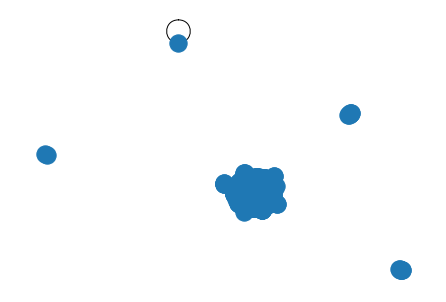

In [21]:
nx.draw(graph1)

In [ ]:
#stupido tentativo di visualizzare il grafo non ci riesco in nessun modo, se qualcun altro lo sa fare top 
#altrimenti si può benissimo cancellare

weights = [i['weight'] for i in dict(graph1.edges).values()]
labels = [i for i in dict(graph1.nodes).keys()]
labels = {i:i for i in dict(graph1.nodes).keys()}

fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(graph1)
nx.draw_networkx_nodes(graph1, pos, ax = ax, labels=True)
nx.draw_networkx_edges(graph1, pos, width=durations, ax=ax)
_ = nx.draw_networkx_labels(graph1, pos, labels, ax=ax)

**Second graph**: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [16]:
graph2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')

In [17]:
graph2.add_nodes_from(nodes['node'], type=nodes['type'])

In [82]:
nx.info(graph2)

'Graph with 19091 nodes and 96104 edges'

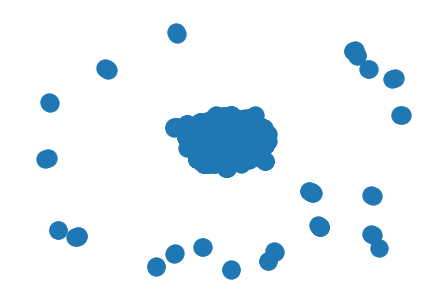

In [85]:
nx.draw(graph2)

## 2. Backend Implementation

### 2.1. Functionality 1 - Extract the graph's features

As the number of nodes and edges grows, it might be useful to work on a subset of the data to reduce computation time and improve the network visualization.
<br>
<br>
For this reason we will consider the **Top N heroes**: which are the **N** heroes who have appeared in the most number of comics

In [87]:
def top_N(df, N):return df.groupby('hero').count().sort_values(['comic'], ascending = False).iloc[:N]

In [90]:
test = top_N(edges, 5)

In [92]:
test

,comic
hero,
SPIDER-MAN/PETER PARKER,1577
CAPTAIN AMERICA,1334
IRON MAN/TONY STARK,1150
THING/BENJAMIN J. GR,963
THOR/DR. DONALD BLAK,956


In [81]:
edges.groupby('comic').count().sort_values(['hero'], ascending= False)

,hero
comic,
COC 1,111
IW 3,91
IW 1,90
H2 279,87
IW 4,80
...,...
MYSTIC COMICS 10,1
N 2/4,1
N 37,1


The output for this functionality must contain:
- the number of nodes in the network (if type 2, report for both node types)
- the number of collaborations of each superhero with the others (*! Only if type 1*)
- the number of heroes that have appeared in each comic (*! Only if type 2*)
- the network's density
- the network's degree distribution
- the average degree of the network
- the network's hubs
- whether the network is spares or dense

let's define some functions

In [79]:
edges.groupby('comic').count()

,hero
comic,
2001 10,1
2001 8,1
2001 9,1
A '00,23
A '01,9
...,...
YOUNG MEN 26,1
YOUNG MEN 27,1
YOUNG MEN 28,1


#### Density of a graph

Both in the case of graph type 1 and 2, we are dealing with *undirected* graph, thus the density can be computed as: $$d = \frac{2\cdot m}{n \cdot (n-1)}$$
where **n** is the number of nodes and **m** is the number of edges in the graph.

In [68]:
def graph_density(G):
    return 2*len(list(G.edges())) / (len(list(G.nodes()))*(len(list(G.nodes())-1)))

#### Degree Distribution

The degree distribution $P(k)$ of a graph is the fraction of nodes in the network with degree $k$.
<br>

Thus if the there are $n$ nodes in total in a network, and $n_k$ of them have degree $k$, we have: $$P(k)=\frac{n_k}{n}$$



#### Network's hubs

Hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution


#### Sparsity vs. Density

We can say that, if the graph's density is close to 1, the graph **dense**, meanwhile it is **sparse** if the density is close to 0. 


In [99]:
class func1():

    def __init__(self, graph, graph_type):
        self.graph = graph
        self.graph_type = graph_type


    def count_nodes(self):

        if self.graph_type == 1:
            g1 = self.graph
            nodes = set()

            for edge in g1.edges():
                nodes.add(edge[0])
                nodes.add(edge[1])

            return len(nodes)
        elif self.graph_type == 2:
            g2 = self.graph
            heroes = set()
            comics = set()

            for edge in g2.edges():

                heroes.add(edge[0])
                comics.add(edge[1])
            return len(heroes), len(comics)

    def count_collaborations(self):

        if self.graph_type == 1:

            degrees = {}

            for edge in self.graph.edges():
                if edge[0] not in degrees:
                    degrees[edge[0]] = 0
                if edge[1] not in degrees:
                    degrees[edge[1]] = 0
                degrees[edge[0]] += 1
                degrees[edge[1]] += 1
            
            return degrees
        else:
            print('Functionality doesn`t exist for this type of graph')

    def comic_appearence(self):

        if self.graph_type == 2:

            comics = dict()

            for edge in self.graph.edges():
                
                if edge[1] not in comics:
                    comics[edge[1]] = 0
                
                comics[edge[1]] += 1

            return comics
        else:
            print('Functionality doesn`t exist for this type of graph')

    def graph_density(self):
        return 2*len(list(self.graph.edges())) / (len(list(self.graph.nodes()))*(len(list(self.graph.nodes()))-1))

    def degree_distro(self):

        degree = {}

        for edge in self.graph.edges():
            if edge[0] not in degree:
                degree[edge[0]] = 0
            else:
                degree[edge[0]] += 1
            
            if edge[1] not in degree:
                degree[edge[1]] = 0
            else:
                degree[edge[1]] += 1

        distros = {}

        for i in degree:
            distros.update({i: degree[i]/len(degree)})

        return distros

    def average_degree(self):

        degree = {}

        for edge in self.graph.edges():
            if edge[0] not in degree:
                degree[edge[0]] = 0
            else:
                degree[edge[0]] += 1
            
            if edge[1] not in degree:
                degree[edge[1]] = 0
            else:
                degree[edge[1]] += 1

        degree_list = list(degree.values())

        return sum(degree_list)/len(degree)

    def find_hubs(self):

        distro_dict = self.degree_distro()

        distros = list(distro_dict.values())

        percentiles = np.percentile(distros, 95)
        
        hubs = [i for i in distro_dict.values() if i > percentiles ]

        return hubs

    def check_sparsity(self):

        if self.graph_density() < 0.5:
            return print("The graph is sparse")
        else:
            return print("The graph is dense")

        

In [97]:
test = func1(graph2, graph_type=2)

In [89]:
test.average_degree()

9.068517548454688

In [ ]:
test.degree_distro()

In [ ]:
test.find_hubs()

In [92]:
test.graph_density()

0.0005273960268427368

In [98]:
test.check_sparsity()

The graph is spase
